28838683


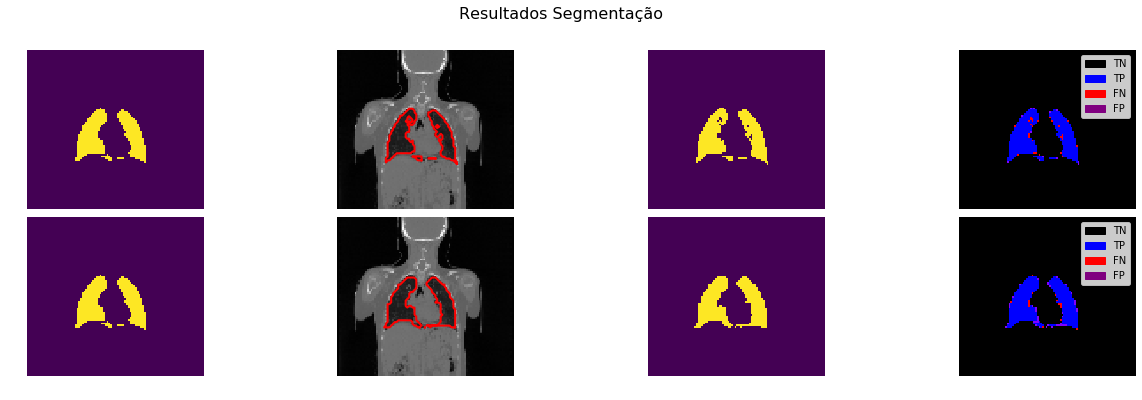

______________________________________________________________________________________________________
31022832


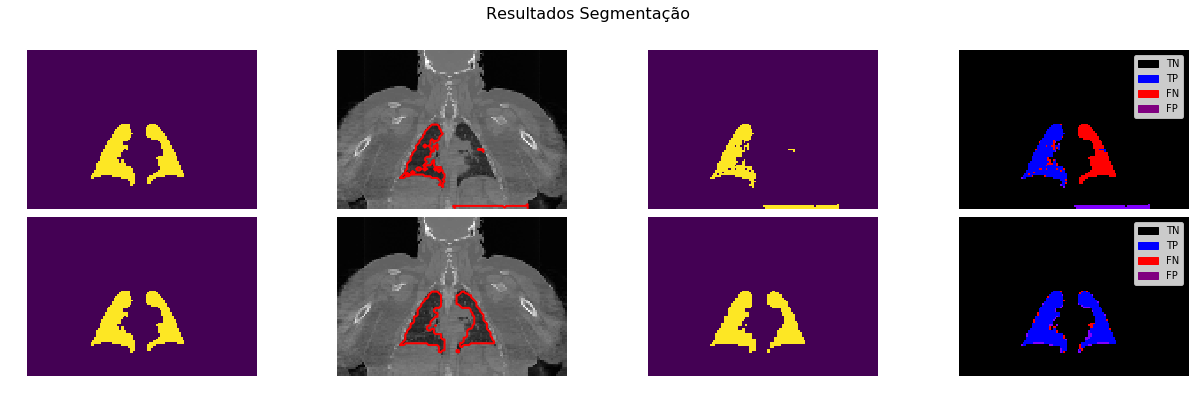

______________________________________________________________________________________________________
36778909


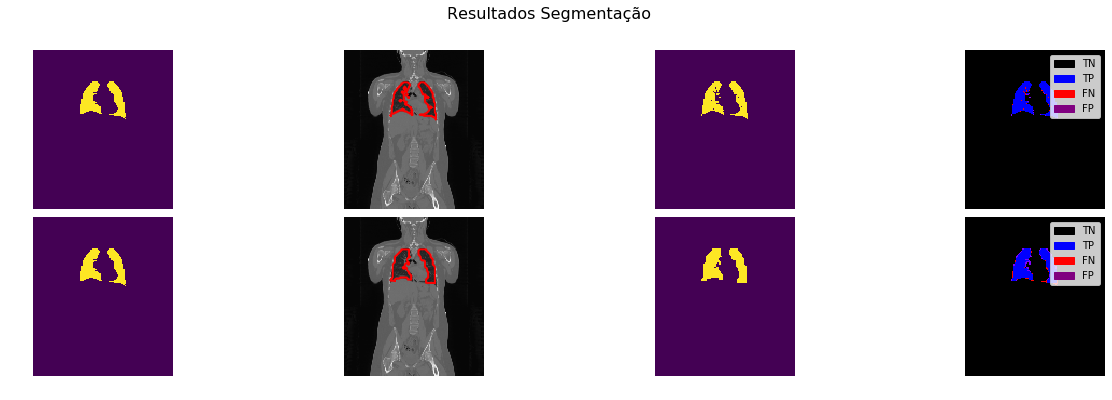

______________________________________________________________________________________________________
37017626


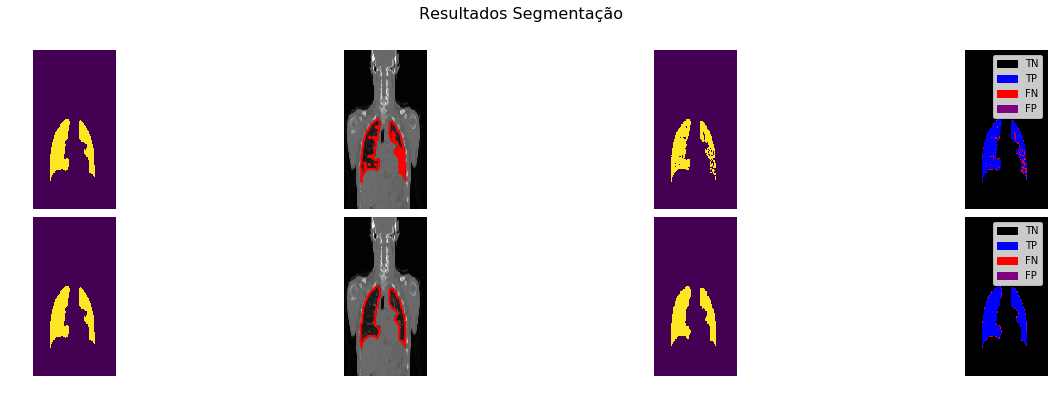

______________________________________________________________________________________________________
37173796


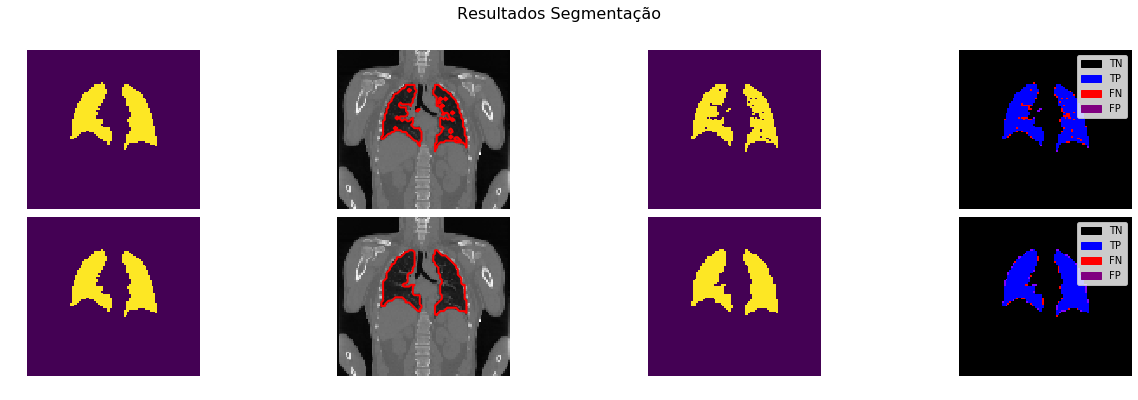

______________________________________________________________________________________________________
37881605


C:\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


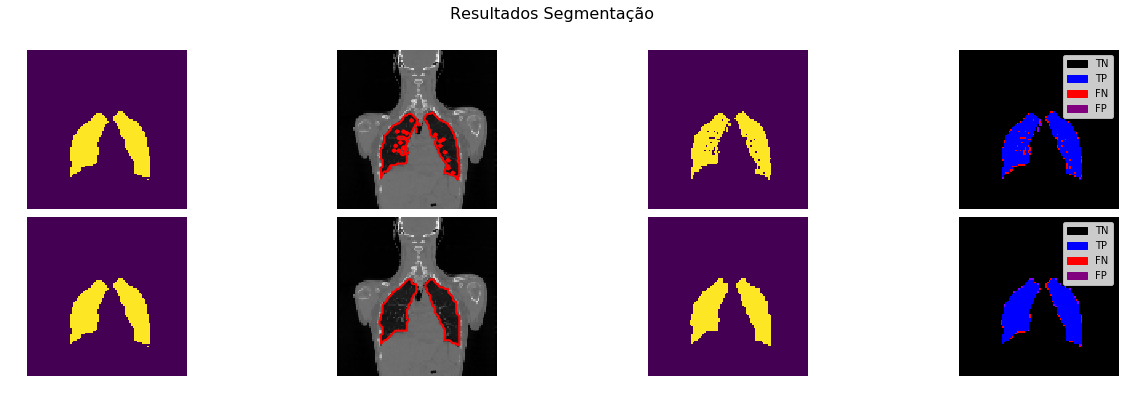

______________________________________________________________________________________________________
38133514


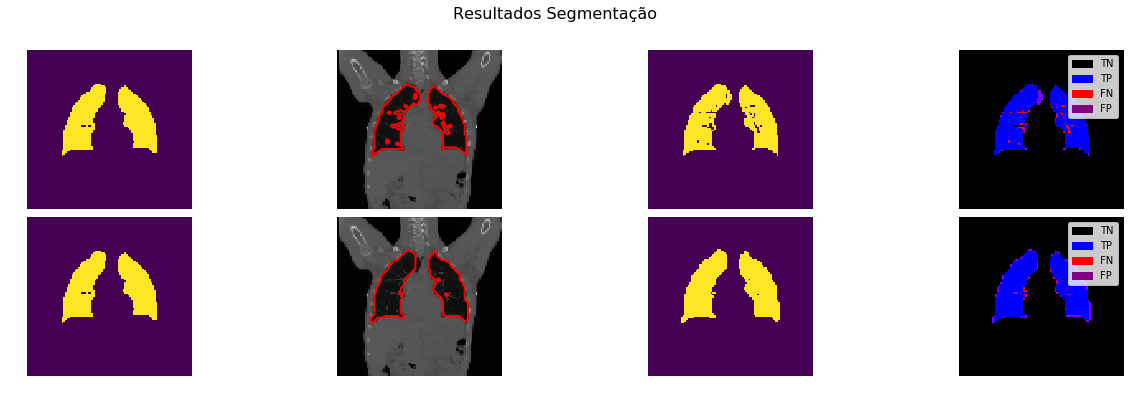

______________________________________________________________________________________________________
39002828


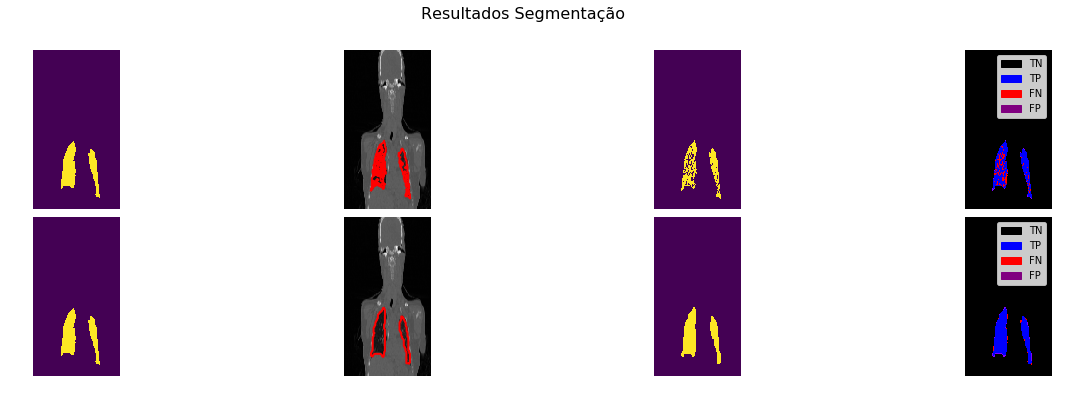

______________________________________________________________________________________________________
39256095


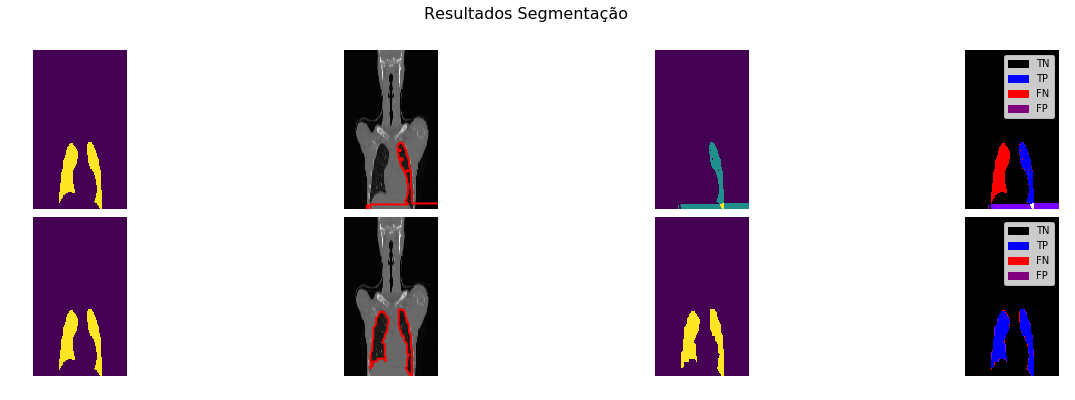

______________________________________________________________________________________________________
40433190


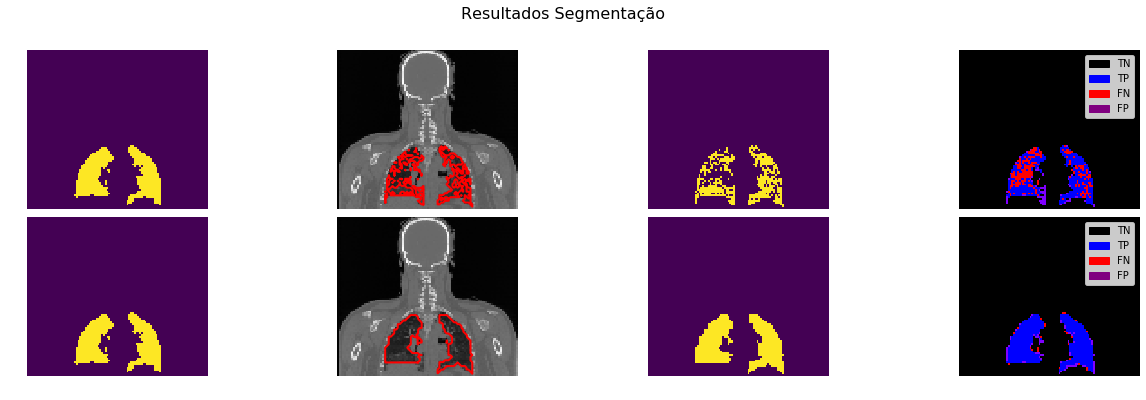

______________________________________________________________________________________________________
47262863


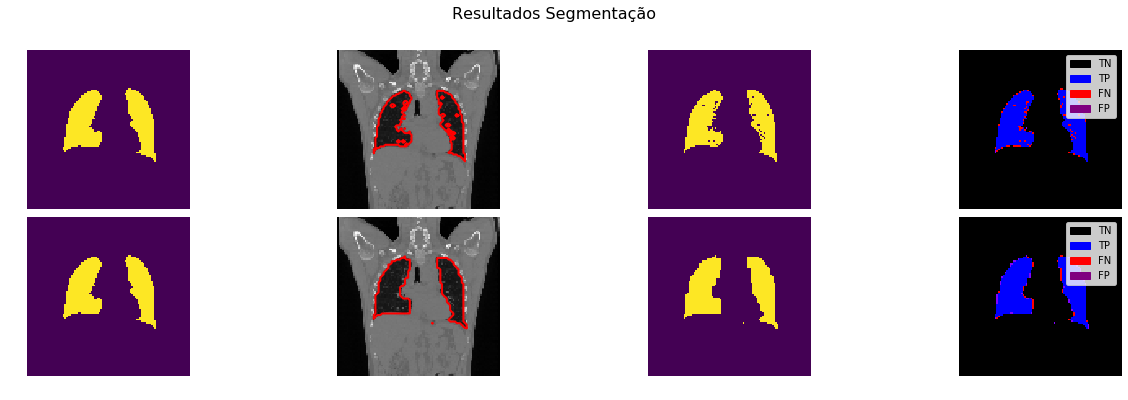

______________________________________________________________________________________________________
47295940


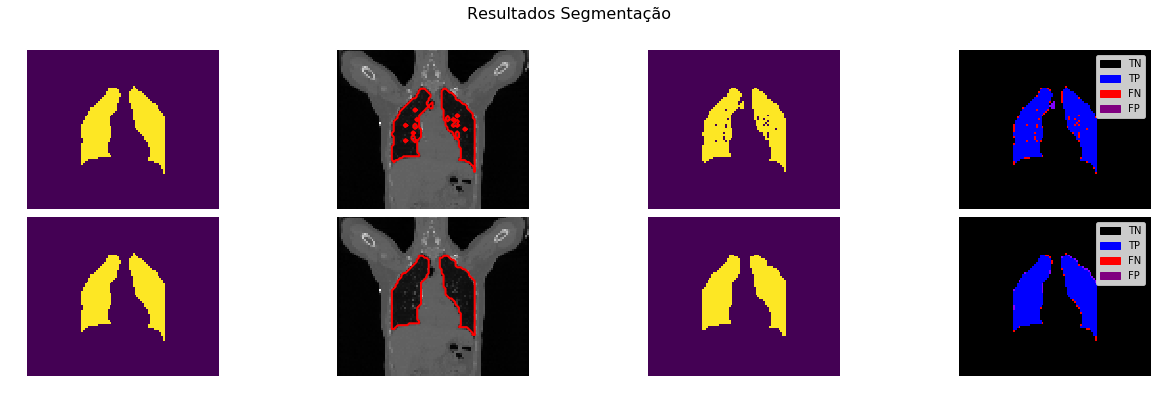

______________________________________________________________________________________________________
48389421


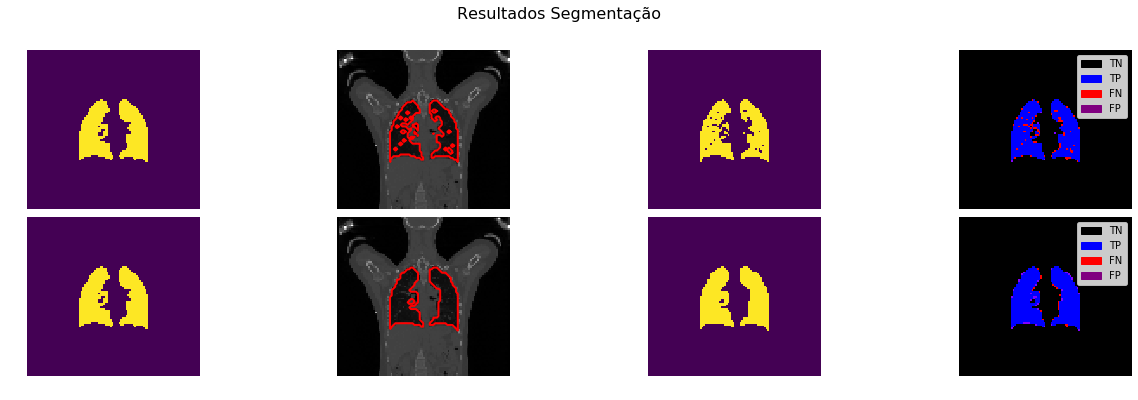

______________________________________________________________________________________________________
49950151


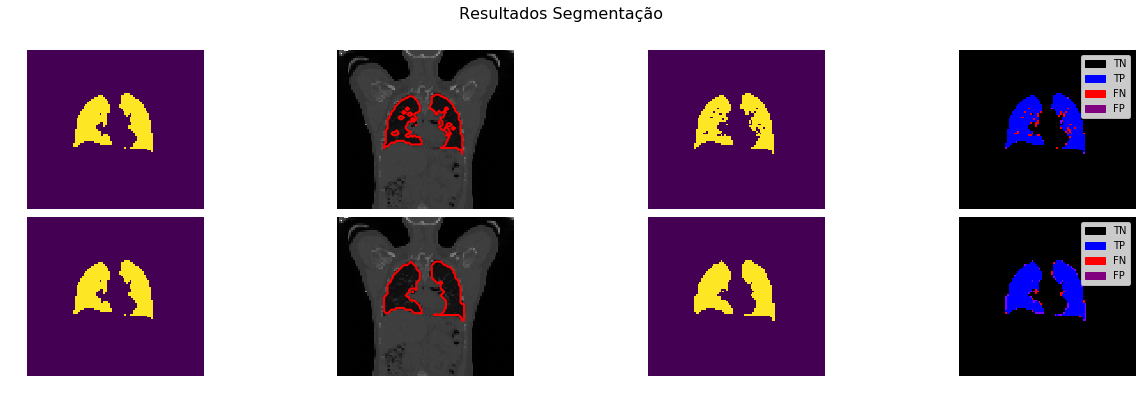

______________________________________________________________________________________________________


In [9]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import scipy.io as spio
import pydicom
import time
from math import log
import nibabel as nib
from nilearn import image
import sys
from scipy.ndimage import zoom
from skimage import measure


from preprocess import arrange_slices

sys.path.insert(0,'C:/3DUnetCNN-master/brats/')
from preprocess_ipo_utils import HU_conversion, read_data

sys.path.insert(0,'3DRegionGrowing/')
from segmentation_functions import resample




def plotResultsSegmentationImage_WithContours(truth_image_ori, prediction_segment_rg, normal_image, contours_rg, prediction_segment_u, contours_u):
    #Code adapted from KenobiShan and from kraskevich, 
    #available on https://codereview.stackexchange.com/questions/177898/calculate-true-positive-false-positive-true-negative-and-false-negative-and-co
     
    prediction_rg = prediction_segment_rg.astype(np.uint8)
    truth_image = truth_image_ori.astype(np.uint8)

    output_image_rg = np.empty(shape=(prediction_rg.shape[0], prediction_segment_rg.shape[1], 4), dtype=np.uint8)

    true_positive_mask_rg = np.logical_and(truth_image ==1 , prediction_rg == 1)
    true_negative_mask_rg = np.logical_and(truth_image ==0 , prediction_rg == 0)
    false_positive_mask_rg = np.logical_and(truth_image ==0 , prediction_rg == 1)
    false_negative_mask_rg = np.logical_and(truth_image ==1 , prediction_rg == 0)
    
    background_mask_rg = np.logical_and(truth_image ==0 , prediction_segment_rg == 0)
    
    # B-G-R-A
    red = [255, 0, 0, 255]
    green = [0, 255, 0, 255]
    blue = [0, 0, 255, 255]
    purple =  [128, 0, 255, 255]
    black = [0, 0, 0, 255]

    output_image_rg[background_mask_rg] = black  
    output_image_rg[true_positive_mask_rg] = blue 
    output_image_rg[true_negative_mask_rg] = black 
    output_image_rg[false_positive_mask_rg] = purple
    output_image_rg[false_negative_mask_rg] = red  
    

    
    fig_2 = plt.figure(figsize=(22,6))
    fig_2.subplots_adjust(hspace=0.05, wspace=0.05)
     
    #Ground truth
    z = fig_2.add_subplot(2,4,1)
    z.axis('off')
    z.imshow(truth_image)
    #z.set_title("Ground truth")
    
    #Contours RG
    y = fig_2.add_subplot(2,4,2)
    y.axis('off')
    y.imshow(normal_image, interpolation='nearest',cmap='gray')
    for n, contour in enumerate(contours_rg):
        y.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)

    #Results RG
    a = fig_2.add_subplot(2,4,3)
    a.axis('off')
    a.imshow(prediction_rg)
    #a.set_title("RG Segmentation results")
    
    #Results TP/TN RG    
    x = fig_2.add_subplot(2,4,4)
    x.axis('off')
    black_patch = mpatches.Patch(color='black', label='TN')
    blue_patch = mpatches.Patch(color='blue', label='TP')
    red_patch = mpatches.Patch(color='red', label='FN')
    purple_patch = mpatches.Patch(color='purple', label='FP')
    plt.legend(handles=[black_patch, blue_patch, red_patch, purple_patch])
    x.imshow(output_image_rg)

    
    #### Line below
    prediction_u = prediction_segment_u.astype(np.uint8)
    
    output_image_u = np.empty(shape=(prediction_u.shape[0], prediction_segment_u.shape[1], 4), dtype=np.uint8)

    true_positive_mask_u = np.logical_and(truth_image ==1 , prediction_u == 1)
    true_negative_mask_u= np.logical_and(truth_image ==0 , prediction_u == 0)
    false_positive_mask_u= np.logical_and(truth_image ==0 , prediction_u == 1)
    false_negative_mask_u = np.logical_and(truth_image ==1 , prediction_u == 0)
    
    background_mask_u = np.logical_and(truth_image ==0 , prediction_segment_u == 0)
    
    output_image_u[background_mask_u] = black  
    output_image_u[true_positive_mask_u] = blue 
    output_image_u[true_negative_mask_u] = black 
    output_image_u[false_positive_mask_u] = purple
    output_image_u[false_negative_mask_u] = red  
    
    #Ground truth
    z_2 = fig_2.add_subplot(2,4,5)
    z_2.axis('off')
    z_2.imshow(truth_image)
    #z_2.set_title("Ground truth")
    
    
    #Results contours
    y_2 = fig_2.add_subplot(2,4,6)
    y_2.axis('off')
    y_2.imshow(normal_image, interpolation='nearest',cmap='gray')
    for n, contour in enumerate(contours_u):
        y_2.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)

    #Segmentation results unet
    a_2 = fig_2.add_subplot(2,4,7)
    a_2.axis('off')
    a_2.imshow(prediction_u)
    #a_2.set_title("U-Net Segmentation results")
        
    #Results TP/TN Unet
    x_2 = fig_2.add_subplot(2,4,8)
    x_2.axis('off')
    black_patch = mpatches.Patch(color='black', label='TN')
    blue_patch = mpatches.Patch(color='blue', label='TP')
    red_patch = mpatches.Patch(color='red', label='FN')
    purple_patch = mpatches.Patch(color='purple', label='FP')
    plt.legend(handles=[black_patch, blue_patch, red_patch, purple_patch])
    x_2.imshow(output_image_u)

    plt.show()
    return fig_2

#______________________________________________________________________________________________________

patient_id = "40433190"

prediction_path = "C:/results/23teste/3DUnetCNN-master/brats/prediction/"
prediction_folder = os.listdir(prediction_path)
in_folder_2= "G:/CTimagens/original/"
mask_folder = "G:/Masks/pares/"
separate_mask_folder = "G:/Masks/separated/"
separation_path = "G:/Results/Separator/"
rg_results_path = "G:/Results/segmentation_results/Iterative/third/"

for patient_id in prediction_folder:
    print(patient_id)
    in_folder= "G:/Ana Tese/CISUC-BD/Imagens CT/original/"+patient_id+"/"

    #predict_file
    prediction_file = prediction_path+patient_id+'/'+"{0}_prediction.nii.gz" 
    prediction_image = nib.load(prediction_file)
    prediction = prediction_image.get_data()

    truth = np.load(mask_folder+'mask_'+patient_id+'.npy')

    #volume
    slices, affine,first_slice = read_data(in_folder, True)
    scans = arrange_slices(in_folder_2, patient_id)
    hu_volume=HU_conversion(slices, first_slice)
    hu_array = np.array(hu_volume)
    trans = np.flip(hu_array.transpose(2,1,0),2)
    data = np.flip(trans,0)
    volume_resampled,spacing = resample(data, scans, [5,5,5])

    #resampling Unet to original shape 
    resize_factor = np.array(truth.shape) / np.array(prediction.shape)
    new_real_shape = prediction.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / prediction.shape
    result_orig_size = zoom(prediction, real_resize_factor, order=1)
    result_resampled_unet, spacing = resample(result_orig_size, scans, [5,5,5])
    unet_boolean= np.where(result_resampled_unet>0.5, 1, 0)

    #Ground truth mask
    mask = np.load(mask_folder+"mask_"+patient_id+'.npy')
    ground_truth_resampled, spacing = resample(mask, scans, [5,5,5]) 
    mask_boolean= np.where(ground_truth_resampled>0.5, 1, 0)

    #RG result
    probable_name_left = "3DVolumeSegmented_"+patient_id+"_left"
    probable_rg_file_left = [i for i in os.listdir(rg_results_path) if os.path.isfile(os.path.join(rg_results_path,i)) and \
     probable_name_left in i]
    if len(probable_rg_file_left) != 0:
        volume_RG = np.load(rg_results_path+probable_rg_file_left[0])
        volume_RG_boolean_left= np.where(volume_RG==True, 1, 0)

    probable_name_right = "3DVolumeSegmented_"+patient_id+"_right"
    probable_rg_file_right = [i for i in os.listdir(rg_results_path) if os.path.isfile(os.path.join(rg_results_path,i)) and \
     probable_name_right in i]
    if len(probable_rg_file_right) != 0:
        volume_RG = np.load(rg_results_path+probable_rg_file_right[0])
        volume_RG_boolean_right= np.where(volume_RG==True, 1, 0)

    both_segment_rg = volume_RG_boolean_left+volume_RG_boolean_right

    rows = volume_resampled.shape[1]//2

    contours_rg = measure.find_contours(both_segment_rg[:,rows,:], 0.9)
    contours_u = measure.find_contours(unet_boolean[:,rows,:], 0.9)
    img = plotResultsSegmentationImage_WithContours(mask_boolean[:,rows,:],both_segment_rg[:,rows,:],volume_resampled[:,rows,:], contours_rg,unet_boolean[:,rows,:],contours_u)
    print("______________________________________________________________________________________________________")
    #img = plot_results_segmentation_image(ground_truth_boolean[:,half_rows,:],result_segment_boolean[:,half_rows,:],volume_resampled[:,half_rows,:])
    #truth_image_ori, prediction_segment_rg, normal_image, contours_rg, prediction_segment_u, contours_u

# Applied mask

28838683


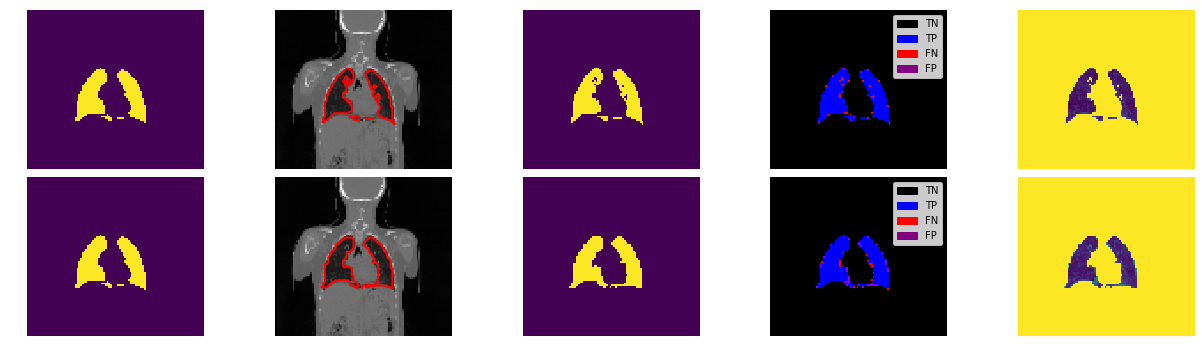

______________________________________________________________________________________________________
31022832


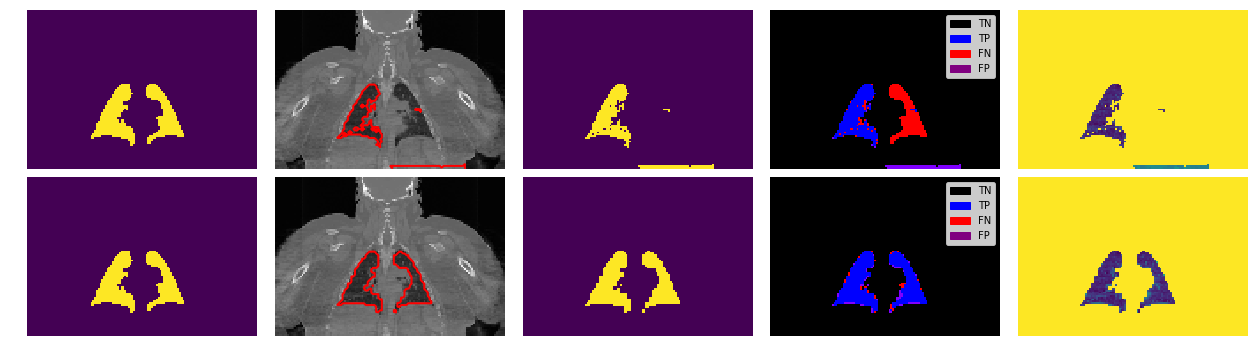

______________________________________________________________________________________________________
36778909


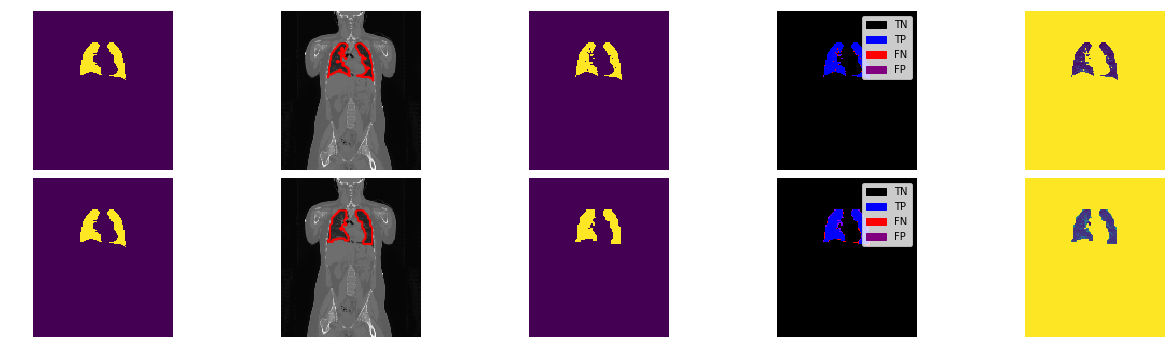

______________________________________________________________________________________________________
37017626


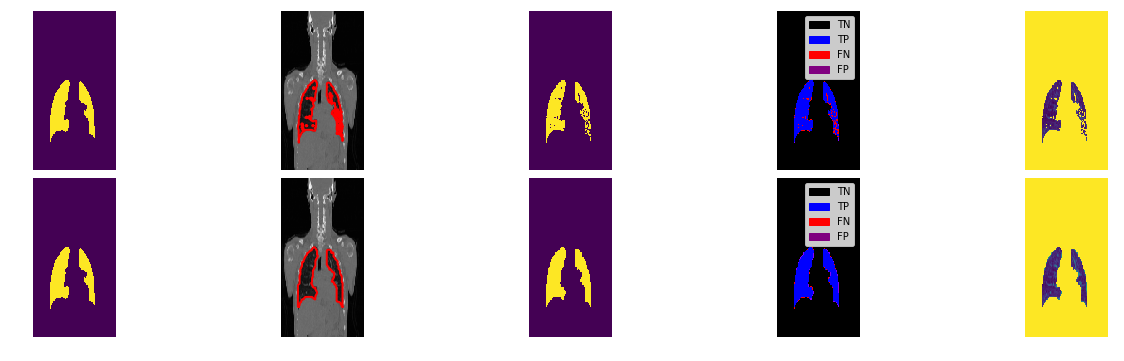

______________________________________________________________________________________________________
37173796


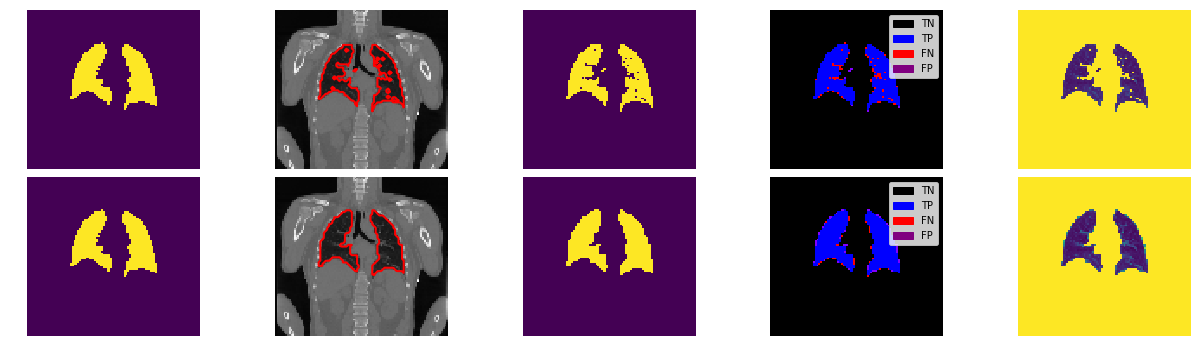

______________________________________________________________________________________________________
37881605


C:\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


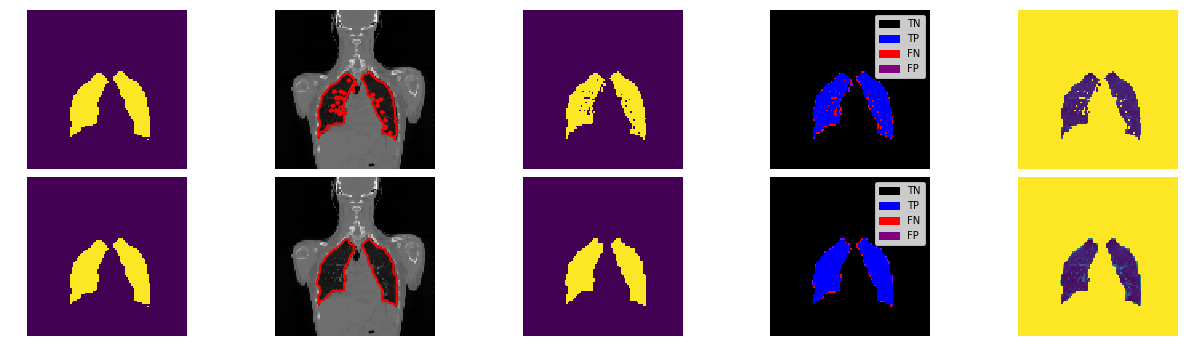

______________________________________________________________________________________________________
38133514


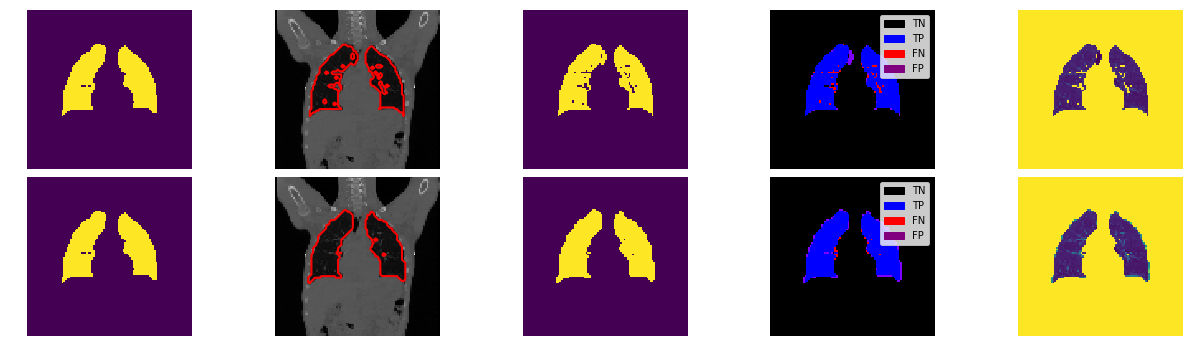

______________________________________________________________________________________________________
39002828


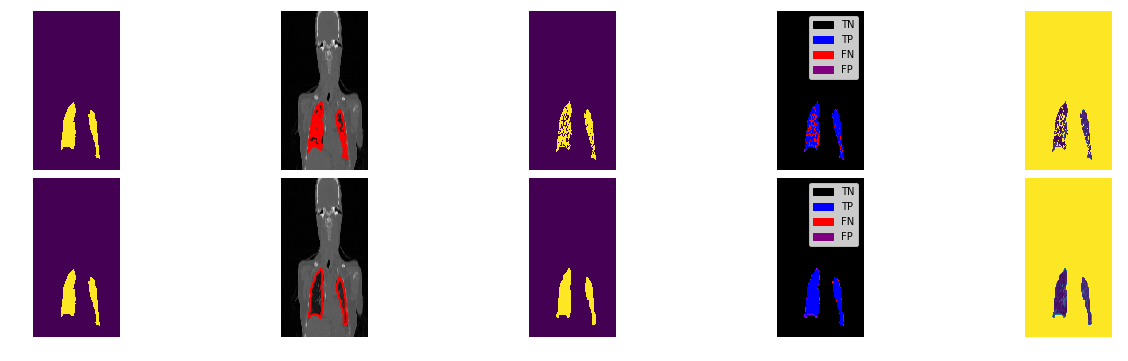

______________________________________________________________________________________________________
39256095


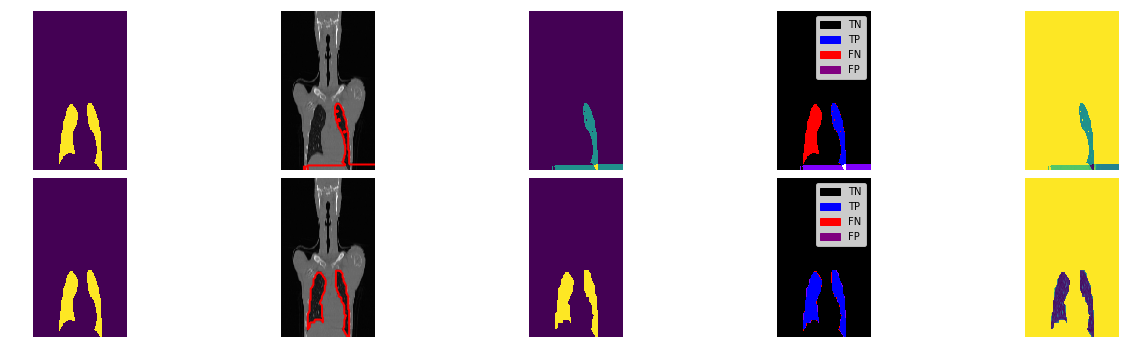

______________________________________________________________________________________________________
40433190


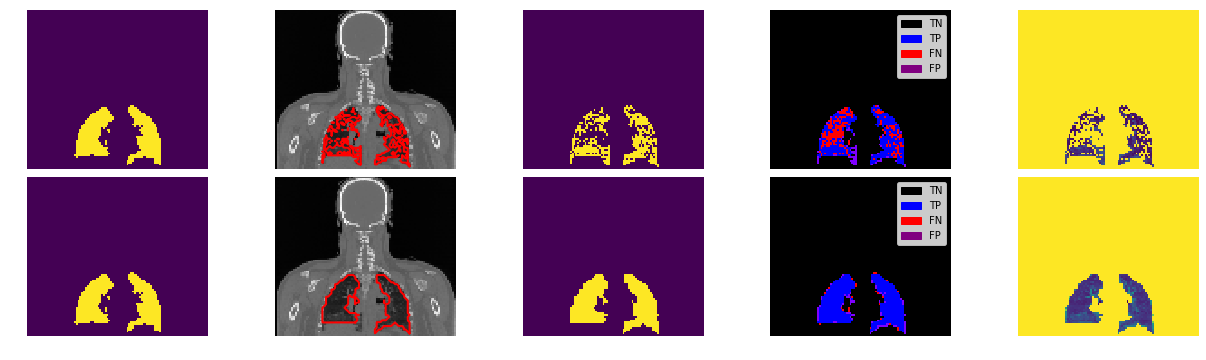

______________________________________________________________________________________________________
47262863


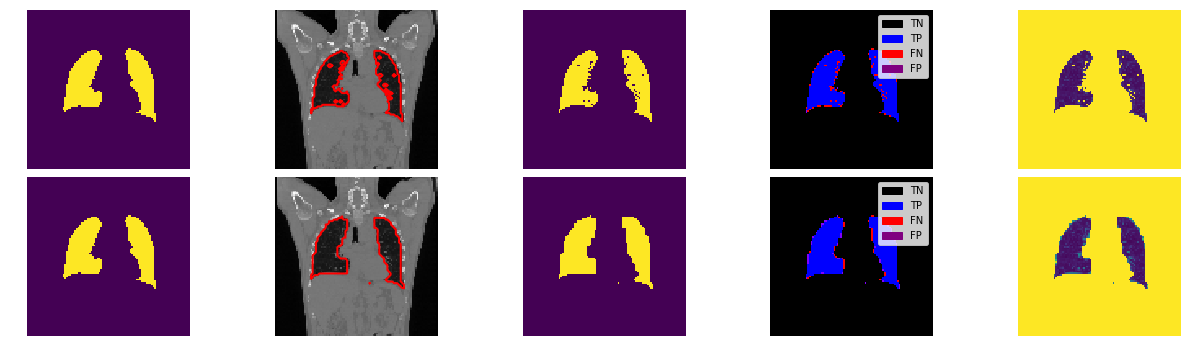

______________________________________________________________________________________________________
47295940


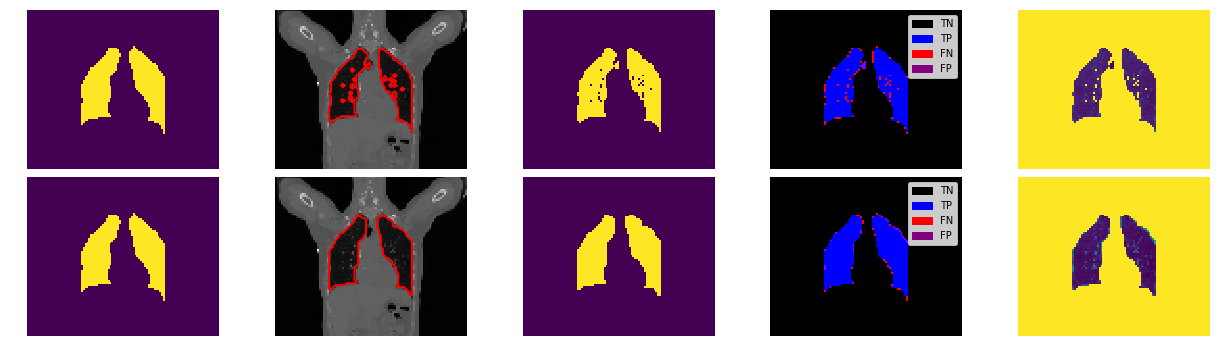

______________________________________________________________________________________________________
48389421


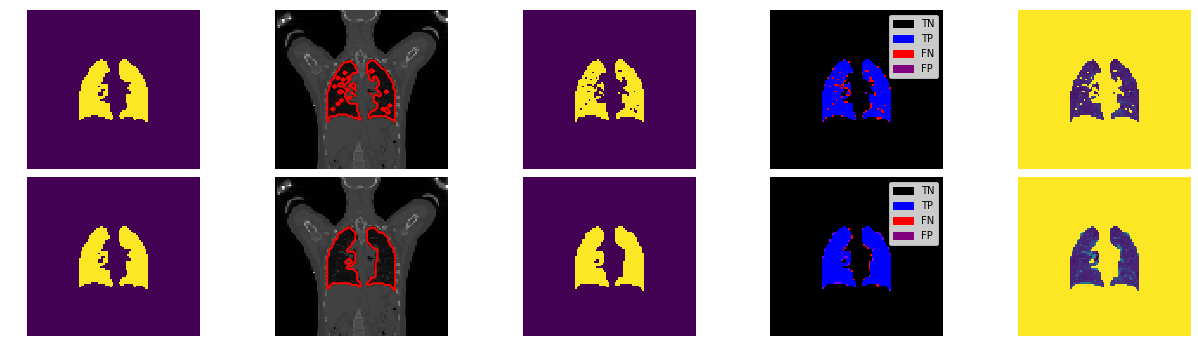

______________________________________________________________________________________________________
49950151


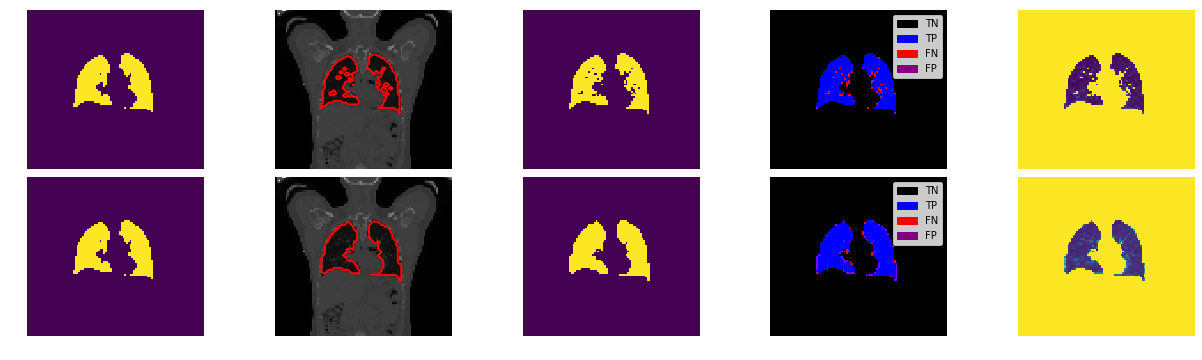

______________________________________________________________________________________________________


In [4]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import scipy.io as spio
import pydicom
import time
from math import log
import nibabel as nib
from nilearn import image
import sys
from scipy.ndimage import zoom
from skimage import measure


from preprocess import arrange_slices

sys.path.insert(0,'C:/3DUnetCNN-master/brats/')
from preprocess_ipo_utils import HU_conversion, read_data

sys.path.insert(0,'3DRegionGrowing/')
from segmentation_functions import resample




def plotResultsSegmentationImage_WithContours(truth_image_ori, prediction_segment_rg, normal_image, contours_rg, prediction_segment_u, contours_u):
    #Code adapted from KenobiShan and from kraskevich, 
    #available on https://codereview.stackexchange.com/questions/177898/calculate-true-positive-false-positive-true-negative-and-false-negative-and-co
     
    prediction_rg = prediction_segment_rg.astype(np.uint8)
    truth_image = truth_image_ori.astype(np.uint8)

    output_image_rg = np.empty(shape=(prediction_rg.shape[0], prediction_segment_rg.shape[1], 4), dtype=np.uint8)

    true_positive_mask_rg = np.logical_and(truth_image ==1 , prediction_rg == 1)
    true_negative_mask_rg = np.logical_and(truth_image ==0 , prediction_rg == 0)
    false_positive_mask_rg = np.logical_and(truth_image ==0 , prediction_rg == 1)
    false_negative_mask_rg = np.logical_and(truth_image ==1 , prediction_rg == 0)
    
    background_mask_rg = np.logical_and(truth_image ==0 , prediction_segment_rg == 0)
    
    # B-G-R-A
    red = [255, 0, 0, 255]
    green = [0, 255, 0, 255]
    blue = [0, 0, 255, 255]
    purple =  [128, 0, 255, 255]
    black = [0, 0, 0, 255]

    output_image_rg[background_mask_rg] = black  
    output_image_rg[true_positive_mask_rg] = blue 
    output_image_rg[true_negative_mask_rg] = black 
    output_image_rg[false_positive_mask_rg] = purple
    output_image_rg[false_negative_mask_rg] = red  
    
    fig_2 = plt.figure(figsize=(22,6))
    fig_2.subplots_adjust(hspace=0.05, wspace=0.05)
    
    #Ground truth
    z = fig_2.add_subplot(2,5,1)
    z.axis('off')
    z.imshow(truth_image)
    #z.set_title("Ground truth")
    
    #Contours RG
    y = fig_2.add_subplot(2,5,2)
    y.axis('off')
    y.imshow(normal_image, interpolation='nearest',cmap='gray')
    for n, contour in enumerate(contours_rg):
        y.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)

    #Results RG
    a = fig_2.add_subplot(2,5,3)
    a.axis('off')
    a.imshow(prediction_rg)
    
    #Results TP/TN RG    
    x = fig_2.add_subplot(2,5,4)
    x.axis('off')
    black_patch = mpatches.Patch(color='black', label='TN')
    blue_patch = mpatches.Patch(color='blue', label='TP')
    red_patch = mpatches.Patch(color='red', label='FN')
    purple_patch = mpatches.Patch(color='purple', label='FP')
    plt.legend(handles=[black_patch, blue_patch, red_patch, purple_patch])
    x.imshow(output_image_rg)
    
    #After aplication of mask    
    x = fig_2.add_subplot(2,5,5)
    x.axis('off')
    x.imshow(normal_image*prediction_rg)

    
    #### Line below
    prediction_u = prediction_segment_u.astype(np.uint8)
    
    output_image_u = np.empty(shape=(prediction_u.shape[0], prediction_segment_u.shape[1], 4), dtype=np.uint8)

    true_positive_mask_u = np.logical_and(truth_image ==1 , prediction_u == 1)
    true_negative_mask_u= np.logical_and(truth_image ==0 , prediction_u == 0)
    false_positive_mask_u= np.logical_and(truth_image ==0 , prediction_u == 1)
    false_negative_mask_u = np.logical_and(truth_image ==1 , prediction_u == 0)
    
    background_mask_u = np.logical_and(truth_image ==0 , prediction_segment_u == 0)
    
    output_image_u[background_mask_u] = black  
    output_image_u[true_positive_mask_u] = blue 
    output_image_u[true_negative_mask_u] = black 
    output_image_u[false_positive_mask_u] = purple
    output_image_u[false_negative_mask_u] = red  
    
    #Ground truth
    z_2 = fig_2.add_subplot(2,5,6)
    z_2.axis('off')
    z_2.imshow(truth_image)
    #z_2.set_title("Ground truth")
    
    
    #Results contours
    y_2 = fig_2.add_subplot(2,5,7)
    y_2.axis('off')
    y_2.imshow(normal_image, interpolation='nearest',cmap='gray')
    for n, contour in enumerate(contours_u):
        y_2.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)

    #Segmentation results unet
    a_2 = fig_2.add_subplot(2,5,8)
    a_2.axis('off')
    a_2.imshow(prediction_u)
        
    #Results TP/TN Unet
    x_2 = fig_2.add_subplot(2,5,9)
    x_2.axis('off')
    black_patch = mpatches.Patch(color='black', label='TN')
    blue_patch = mpatches.Patch(color='blue', label='TP')
    red_patch = mpatches.Patch(color='red', label='FN')
    purple_patch = mpatches.Patch(color='purple', label='FP')
    plt.legend(handles=[black_patch, blue_patch, red_patch, purple_patch])
    x_2.imshow(output_image_u)

    #After aplication of mask    
    x = fig_2.add_subplot(2,5,10)
    x.axis('off')
    x.imshow(normal_image*prediction_u)
    plt.show()
    
    return fig_2

#______________________________________________________________________________________________________

#patient_id = "40433190"

prediction_path = "C:/results/23teste/3DUnetCNN-master/brats/prediction/"
prediction_folder = os.listdir(prediction_path)
in_folder_2= "G:/CTimages/original/"
mask_folder = "G:/Masks/pares/"
separate_mask_folder = "G:/Masks/separated/"
separation_path = "G:/Results/Separator/"
rg_results_path = "G:/Results/segmentation_results/Iterative/third/"

for patient_id in prediction_folder:
    print(patient_id)
    in_folder= "G:/CTimages/original/"+patient_id+"/"


    #predict_file
    prediction_file = prediction_path+patient_id+'/'+"{0}_prediction.nii.gz"
    prediction_image = nib.load(prediction_file)
    prediction = prediction_image.get_data()
    truth = np.load(mask_folder+'mask_'+patient_id+'.npy')

    #volume
    slices, affine,first_slice = read_data(in_folder, True)
    scans = arrange_slices(in_folder_2, patient_id)
    hu_volume=HU_conversion(slices, first_slice)
    hu_array = np.array(hu_volume)
    trans = np.flip(hu_array.transpose(2,1,0),2)
    data = np.flip(trans,0)
    volume_resampled,spacing = resample(data, scans, [5,5,5])

    #resampling Unet to original shape 
    resize_factor = np.array(truth.shape) / np.array(prediction.shape)
    new_real_shape = prediction.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / prediction.shape
    result_orig_size = zoom(prediction, real_resize_factor, order=1)
    result_resampled_unet, spacing = resample(result_orig_size, scans, [5,5,5])
    unet_boolean= np.where(result_resampled_unet>0.5, 1, 0)

    #Ground truth mask 
    mask = np.load(mask_folder+"mask_"+patient_id+'.npy')
    ground_truth_resampled, spacing = resample(mask, scans, [5,5,5]) 
    mask_boolean= np.where(ground_truth_resampled>0.5, 1, 0)


    #RG result
    probable_name_left = "3DVolumeSegmented_"+patient_id+"_left"
    probable_rg_file_left = [i for i in os.listdir(rg_results_path) if os.path.isfile(os.path.join(rg_results_path,i)) and \
     probable_name_left in i]
    if len(probable_rg_file_left) != 0:
        volume_RG = np.load(rg_results_path+probable_rg_file_left[0])
        volume_RG_boolean_left= np.where(volume_RG==True, 1, 0)

    probable_name_right = "3DVolumeSegmented_"+patient_id+"_right"
    probable_rg_file_right = [i for i in os.listdir(rg_results_path) if os.path.isfile(os.path.join(rg_results_path,i)) and \
     probable_name_right in i]
    if len(probable_rg_file_right) != 0:
        volume_RG = np.load(rg_results_path+probable_rg_file_right[0])
        volume_RG_boolean_right= np.where(volume_RG==True, 1, 0)

    both_segment_rg = volume_RG_boolean_left+volume_RG_boolean_right
        
    #Figure
    rows = volume_resampled.shape[1]//2

    contours_rg = measure.find_contours(both_segment_rg[:,rows,:], 0.9)
    contours_u = measure.find_contours(unet_boolean[:,rows,:], 0.9)
    img = plotResultsSegmentationImage_WithContours(mask_boolean[:,rows,:],both_segment_rg[:,rows,:],volume_resampled[:,rows,:], contours_rg,unet_boolean[:,rows,:],contours_u)
    
    img_folder = "C:/images/segmentation_results/applied mask/"
    
    img.savefig(img_folder+patient_id+'.png', bbox_inches='tight')
    print("______________________________________________________________________________________________________")
    # img = plot_results_segmentation_image(ground_truth_boolean[:,half_rows,:],result_segment_boolean[:,half_rows,:],volume_resampled[:,half_rows,:])
    # truth_image_ori, prediction_segment_rg, normal_image, contours_rg, prediction_segment_u, contours_u

# With seed

28838683
j: (57, 53, 36)
j: (52, 53, 60)


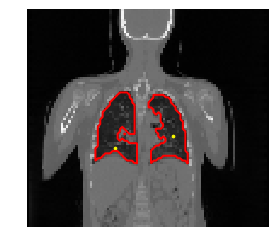

______________________________________________________________________________________________________
31022832
j: (69, 63, 50)
j: (56, 63, 78)


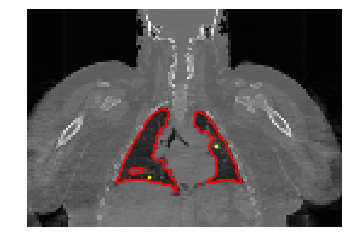

______________________________________________________________________________________________________
36778909
j: (53, 68, 53)
j: (43, 68, 77)


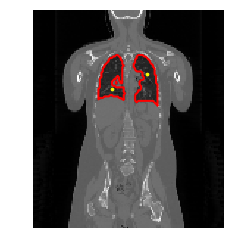

______________________________________________________________________________________________________
37017626
j: (142, 52, 34)
j: (125, 52, 66)


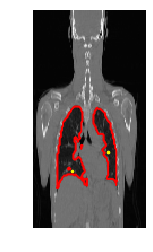

______________________________________________________________________________________________________
37173796
j: (43, 55, 37)
j: (40, 54, 63)


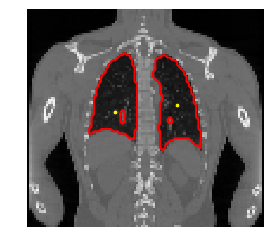

______________________________________________________________________________________________________
37881605


C:\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


j: (58, 56, 39)
j: (60, 55, 66)


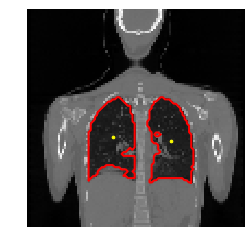

______________________________________________________________________________________________________
38133514
j: (36, 62, 36)
j: (56, 62, 64)


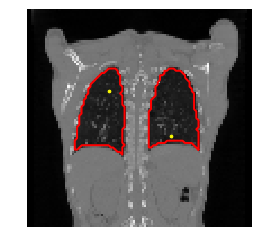

______________________________________________________________________________________________________
39002828
j: (148, 56, 43)
j: (156, 56, 69)


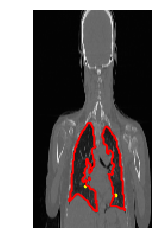

______________________________________________________________________________________________________
39256095
j: (143, 66, 38)
j: (130, 66, 65)


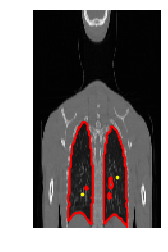

______________________________________________________________________________________________________
40433190
j: (69, 52, 38)
j: (69, 52, 64)


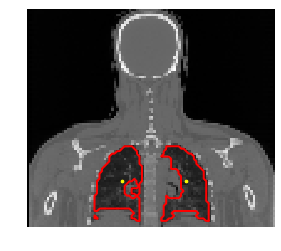

______________________________________________________________________________________________________
47262863
j: (57, 52, 38)
j: (47, 52, 67)


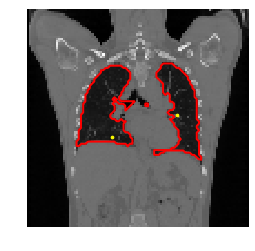

______________________________________________________________________________________________________
47295940
j: (43, 62, 39)
j: (36, 62, 60)


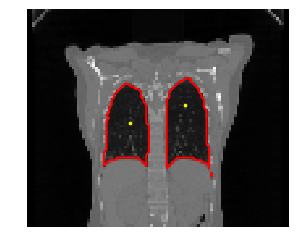

______________________________________________________________________________________________________
48389421
j: (54, 50, 39)
j: (51, 52, 62)


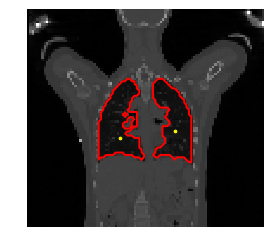

______________________________________________________________________________________________________
49950151
j: (45, 49, 38)
j: (42, 49, 63)


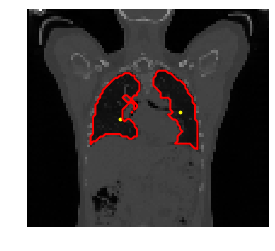

______________________________________________________________________________________________________


In [20]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import scipy.io as spio
import pydicom
import time
from math import log
import nibabel as nib
from nilearn import image
import sys
from preprocess import creating_mask
from scipy.ndimage import zoom
from skimage import measure


from preprocess import arrange_slices

sys.path.insert(0,'C:/3DUnetCNN-master/brats/')
from preprocess_ipo_utils import HU_conversion, read_data

sys.path.insert(0,'3DRegionGrowing/')
from segmentation_functions import resample




def plotResultsSegmentationImage_WithContours(truth_image_ori, prediction_segment_rg, normal_image, contours_rg, prediction_segment_u, contours_u,seed_1,seed_2):
    #Code adapted from KenobiShan and from kraskevich, 
    #available on https://codereview.stackexchange.com/questions/177898/calculate-true-positive-false-positive-true-negative-and-false-negative-and-co
     
    prediction_rg = prediction_segment_rg.astype(np.uint8)
    truth_image = truth_image_ori.astype(np.uint8)

    output_image_rg = np.empty(shape=(prediction_rg.shape[0], prediction_segment_rg.shape[1], 4), dtype=np.uint8)

    true_positive_mask_rg = np.logical_and(truth_image ==1 , prediction_rg == 1)
    true_negative_mask_rg = np.logical_and(truth_image ==0 , prediction_rg == 0)
    false_positive_mask_rg = np.logical_and(truth_image ==0 , prediction_rg == 1)
    false_negative_mask_rg = np.logical_and(truth_image ==1 , prediction_rg == 0)
    
    background_mask_rg = np.logical_and(truth_image ==0 , prediction_segment_rg == 0)
    
    # B-G-R-A
    red = [255, 0, 0, 255]
    green = [0, 255, 0, 255]
    blue = [0, 0, 255, 255]
    purple =  [128, 0, 255, 255]
    black = [0, 0, 0, 255]

    output_image_rg[background_mask_rg] = black  
    output_image_rg[true_positive_mask_rg] = blue 
    output_image_rg[true_negative_mask_rg] = black 
    output_image_rg[false_positive_mask_rg] = purple
    output_image_rg[false_negative_mask_rg] = red  
    
    fig_2 = plt.figure(figsize=(22,6))    
    fig_2.subplots_adjust(hspace=0.05, wspace=0.05)
    
    
    #Ground truth
    z = fig_2.add_subplot(2,5,1)
    z.axis('off')
    z.imshow(truth_image)
    #z.set_title("Ground truth")
    
    #Contours RG
    y = fig_2.add_subplot(2,5,2)
    y.axis('off')
    y.imshow(normal_image, interpolation='nearest',cmap='gray')
    for n, contour in enumerate(contours_rg):
        y.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
    y.scatter([seed_1[2],seed_2[2]], [seed_1[0],seed_2[0]],c='yellow', s=5)
        
    #Results RG
    a = fig_2.add_subplot(2,5,3)
    a.axis('off')
    a.imshow(prediction_rg)
    #a.set_title("RG Segmentation results")
    
    #Results TP/TN RG    
    x = fig_2.add_subplot(2,5,4)
    x.axis('off')
    black_patch = mpatches.Patch(color='black', label='TN')
    blue_patch = mpatches.Patch(color='blue', label='TP')
    red_patch = mpatches.Patch(color='red', label='FN')
    purple_patch = mpatches.Patch(color='purple', label='FP')
    plt.legend(handles=[black_patch, blue_patch, red_patch, purple_patch])
    x.imshow(output_image_rg)
    
    #After aplication of mask    
    x = fig_2.add_subplot(2,5,5)
    x.axis('off')
    x.imshow(normal_image*prediction_rg)

    
    #### Line below
    prediction_u = prediction_segment_u.astype(np.uint8)
    
    output_image_u = np.empty(shape=(prediction_u.shape[0], prediction_segment_u.shape[1], 4), dtype=np.uint8)

    true_positive_mask_u = np.logical_and(truth_image ==1 , prediction_u == 1)
    true_negative_mask_u= np.logical_and(truth_image ==0 , prediction_u == 0)
    false_positive_mask_u= np.logical_and(truth_image ==0 , prediction_u == 1)
    false_negative_mask_u = np.logical_and(truth_image ==1 , prediction_u == 0)
    
    background_mask_u = np.logical_and(truth_image ==0 , prediction_segment_u == 0)
    
    output_image_u[background_mask_u] = black  
    output_image_u[true_positive_mask_u] = blue 
    output_image_u[true_negative_mask_u] = black 
    output_image_u[false_positive_mask_u] = purple
    output_image_u[false_negative_mask_u] = red  
    
    #Ground truth
    z_2 = fig_2.add_subplot(2,5,6)
    z_2.axis('off')
    z_2.imshow(truth_image)
     
    #Results contours
    y_2 = fig_2.add_subplot(2,5,7)
    y_2.axis('off')
    y_2.imshow(normal_image, interpolation='nearest',cmap='gray')
    for n, contour in enumerate(contours_u):
        y_2.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)

    #Segmentation results unet
    a_2 = fig_2.add_subplot(2,5,8)
    a_2.axis('off')
    a_2.imshow(prediction_u)
    #a_2.set_title("U-Net Segmentation results")
        
    #Results TP/TN Unet
    x_2 = fig_2.add_subplot(2,5,9)
    x_2.axis('off')
    black_patch = mpatches.Patch(color='black', label='TN')
    blue_patch = mpatches.Patch(color='blue', label='TP')
    red_patch = mpatches.Patch(color='red', label='FN')
    purple_patch = mpatches.Patch(color='purple', label='FP')
    plt.legend(handles=[black_patch, blue_patch, red_patch, purple_patch])
    x_2.imshow(output_image_u)

    #After aplication of mask    
    x = fig_2.add_subplot(2,5,10)
    x.axis('off')
    x.imshow(normal_image*prediction_u)
    plt.show()
    
    return fig_2

#______________________________________________________________________________________________________

#patient_id = "40433190"

prediction_path = "C:/results/23teste/3DUnetCNN-master/brats/prediction/"
prediction_folder = os.listdir(prediction_path)
in_folder_2= "G:/CTimages/original/"
mask_folder = "G:/Masks/pares/"
separate_mask_folder = "G:/Masks/separated/"
separation_path = "G:/Results/Separator/"
rg_results_path = "G:/Results/segmentation_results/Iterative/third/"

for patient_id in prediction_folder:
    print(patient_id)
    in_folder= "G:/CTimages/original/"+patient_id+"/"


    #predict_file
    prediction_file = prediction_path+patient_id+'/'+"{0}_prediction.nii.gz" 
    prediction_image = nib.load(prediction_file)
    prediction = prediction_image.get_data()

    truth = np.load(mask_folder+'mask_'+patient_id+'.npy')

    #volume
    slices, affine,first_slice = read_data(in_folder, True)
    scans = arrange_slices(in_folder_2, patient_id)
    hu_volume=HU_conversion(slices, first_slice)
    hu_array = np.array(hu_volume)
    trans = np.flip(hu_array.transpose(2,1,0),2)
    data = np.flip(trans,0)
    volume_resampled,spacing = resample(data, scans, [5,5,5])

    #resampling Unet to original shape 
    resize_factor = np.array(truth.shape) / np.array(prediction.shape)
    new_real_shape = prediction.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / prediction.shape
    result_orig_size = zoom(prediction, real_resize_factor, order=1)
    result_resampled_unet, spacing = resample(result_orig_size, scans, [5,5,5])
    unet_boolean= np.where(result_resampled_unet>0.5, 1, 0)

    #Ground truth mask 
    mask = np.load(mask_folder+"mask_"+patient_id+'.npy')
    ground_truth_resampled, spacing = resample(mask, scans, [5,5,5]) 
    mask_boolean= np.where(ground_truth_resampled>0.5, 1, 0)


    #RG result
    probable_name_left = "3DVolumeSegmented_"+patient_id+"_left"
    probable_rg_file_left = [i for i in os.listdir(rg_results_path) if os.path.isfile(os.path.join(rg_results_path,i)) and \
     probable_name_left in i]
    if len(probable_rg_file_left) != 0:
        volume_RG = np.load(rg_results_path+probable_rg_file_left[0])
        volume_RG_boolean_left= np.where(volume_RG==True, 1, 0)

    probable_name_right = "3DVolumeSegmented_"+patient_id+"_right"
    probable_rg_file_right = [i for i in os.listdir(rg_results_path) if os.path.isfile(os.path.join(rg_results_path,i)) and \
     probable_name_right in i]
    if len(probable_rg_file_right) != 0:
        volume_RG = np.load(rg_results_path+probable_rg_file_right[0])
        volume_RG_boolean_right= np.where(volume_RG==True, 1, 0)

    both_segment_rg = volume_RG_boolean_left+volume_RG_boolean_right
    #ground_truth_both = ground_truth_boolean+ground_truth_boolean_2

    
    #Seed
    seeds_path = "G:/Results/Seeds/third"
    seed_1 = spio.loadmat(seeds_path+'/'+patient_id+'_seed1', squeeze_me=True)["seed1"]
    seed_2 = spio.loadmat(seeds_path+'/'+patient_id+'_seed2', squeeze_me=True)["seed2"]
    
    mask_seed_1 = creating_mask([seed_1],data)
    mask_seed_resampled_1, spacing = resample(mask_seed_1, scans, [5,5,5])
    j_1 = np.unravel_index(np.argmax(mask_seed_resampled_1), mask_seed_resampled_1.shape) #tuple
    
    
    print('j: '+str(j_1))
    mask_seed_2 = creating_mask([seed_2],data)
    mask_seed_resampled_2, spacing = resample(mask_seed_2, scans, [5,5,5])
    j_2 = np.unravel_index(np.argmax(mask_seed_resampled_2), mask_seed_resampled_2.shape) #tuple
    print('j: '+str(j_2))
    
    
    #Figure
    rows = volume_resampled.shape[1]//2
    contours_gt = measure.find_contours(mask_boolean[:,j_1[1],:], 0.9)
    
    #img = plotResultsSegmentationImage_WithContours(mask_boolean[:,rows,:],both_segment_rg[:,rows,:],volume_resampled[:,rows,:], contours_rg,unet_boolean[:,rows,:],contours_u,j_1,j_2)
    
    #img_folder = "C:/images/comparison_results/applied mask/"
    
    #img.savefig(img_folder+patient_id+'.png', bbox_inches='tight')
    
    plt.figure()
    plt.axis('off')
    plt.imshow(volume_resampled[:,np.array(j_1)[1],:],cmap='gray')
    for n, contour in enumerate(contours_gt):
        plt.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
    plt.scatter([j_1[2],j_2[2]], [j_1[0],j_2[0]],c='yellow', s=7)
    plt.savefig(img_folder+patient_id+'_groundtruth'+'.png', bbox_inches='tight')
    plt.show()
    print("______________________________________________________________________________________________________")
    # img = plot_results_segmentation_image(ground_truth_boolean[:,half_rows,:],result_segment_boolean[:,half_rows,:],volume_resampled[:,half_rows,:])
    # truth_image_ori, prediction_segment_rg, normal_image, contours_rg, prediction_segment_u, contours_u
    


# Centroids

10194022
10194022


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:209: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


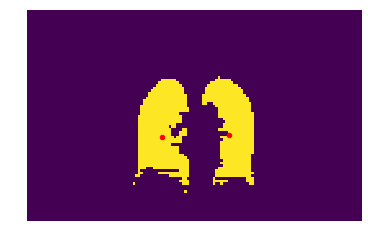

______________________________________________________________________________________________________
28838683
28838683


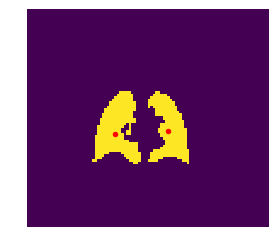

______________________________________________________________________________________________________
31022832
31022832


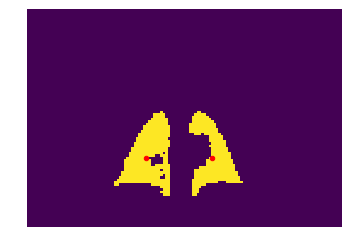

______________________________________________________________________________________________________
31119444
31119444


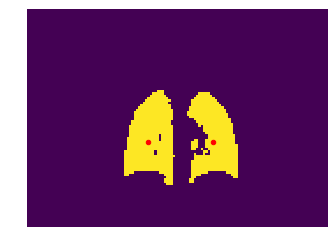

______________________________________________________________________________________________________
32064030


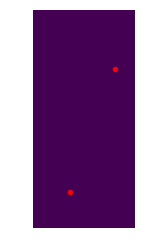

______________________________________________________________________________________________________
32407507
32407507


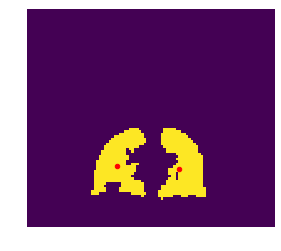

______________________________________________________________________________________________________
33515150
33515150


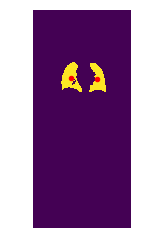

______________________________________________________________________________________________________
34332375
34332375


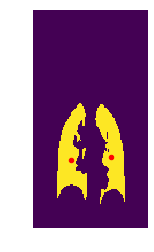

______________________________________________________________________________________________________
35196645


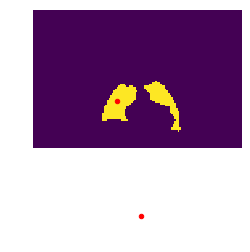

______________________________________________________________________________________________________
35939665
35939665


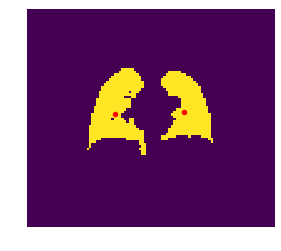

______________________________________________________________________________________________________
36319905
36319905


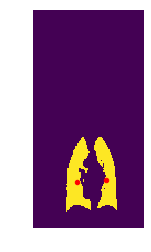

______________________________________________________________________________________________________
36778909
36778909


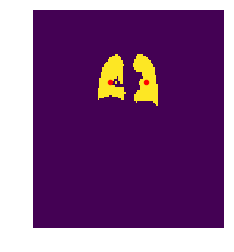

______________________________________________________________________________________________________
36873387
36873387


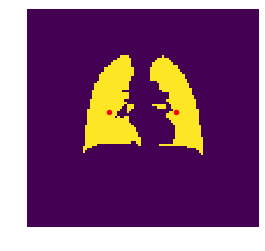

______________________________________________________________________________________________________
37017626
37017626


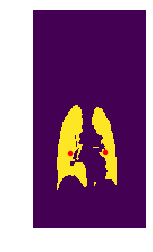

______________________________________________________________________________________________________
37018208
37018208


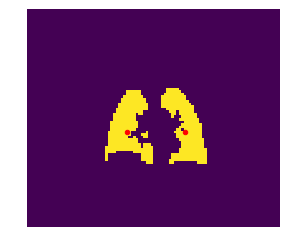

______________________________________________________________________________________________________
37042652
37042652


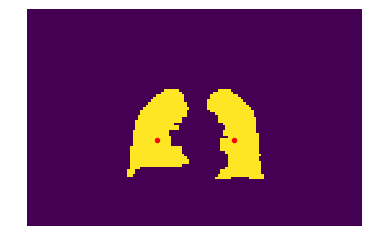

______________________________________________________________________________________________________
37137615
37137615


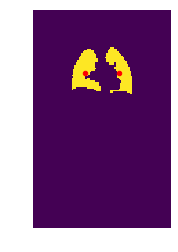

______________________________________________________________________________________________________
37173796
37173796


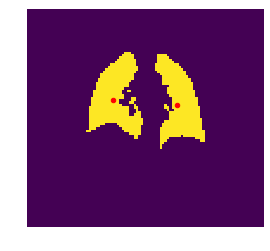

______________________________________________________________________________________________________
37468094
37468094


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in greater


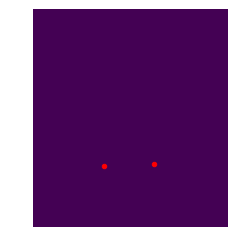

______________________________________________________________________________________________________
37606125
37606125


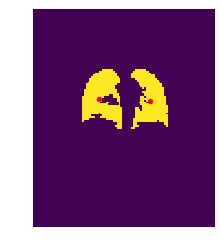

______________________________________________________________________________________________________
37624458
37624458


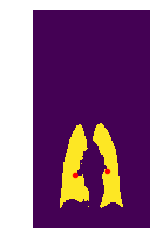

______________________________________________________________________________________________________
37650357
37650357


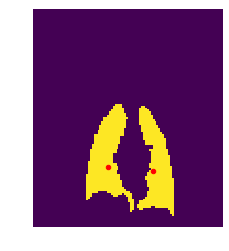

______________________________________________________________________________________________________
37683143
37683143


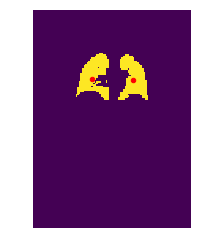

______________________________________________________________________________________________________
37881605
37881605


C:\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


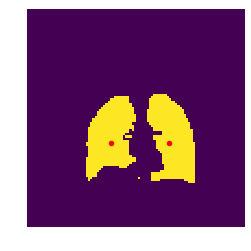

______________________________________________________________________________________________________
37953385
37953385


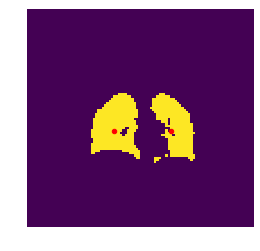

______________________________________________________________________________________________________
38028657
38028657


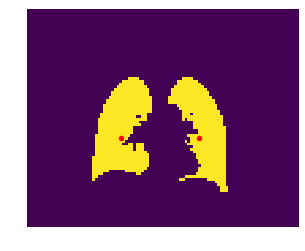

______________________________________________________________________________________________________
38133514
38133514


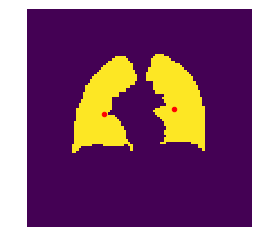

______________________________________________________________________________________________________
38564873
38564873


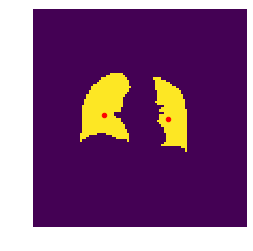

______________________________________________________________________________________________________
39002828
39002828


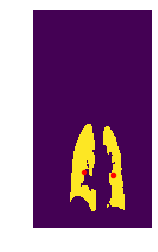

______________________________________________________________________________________________________
39137852
39137852


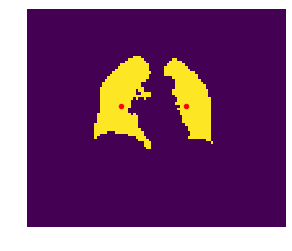

______________________________________________________________________________________________________
39256095
39256095


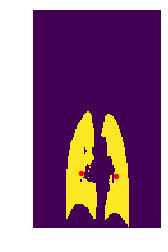

______________________________________________________________________________________________________
39524591
39524591


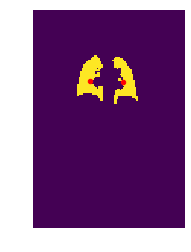

______________________________________________________________________________________________________
39819471
39819471


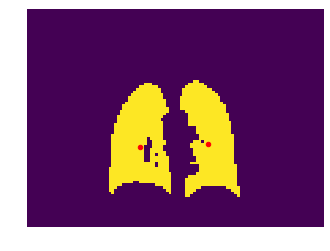

______________________________________________________________________________________________________
39844012
39844012


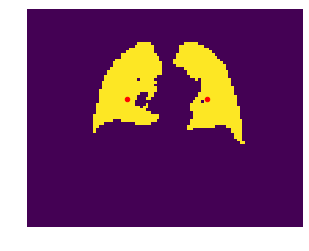

______________________________________________________________________________________________________
39859629
39859629


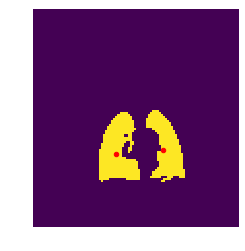

______________________________________________________________________________________________________
39929954
39929954


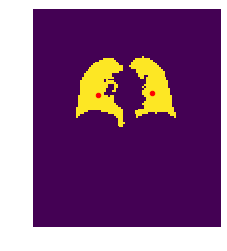

______________________________________________________________________________________________________
39980297
39980297


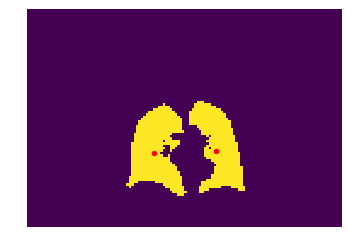

______________________________________________________________________________________________________
40165373
40165373


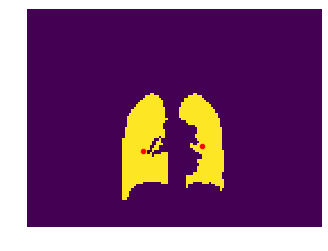

______________________________________________________________________________________________________
40283713
40283713


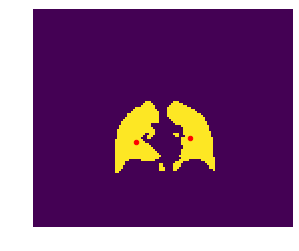

______________________________________________________________________________________________________
40433190
40433190


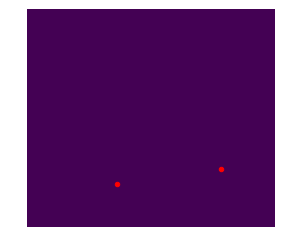

______________________________________________________________________________________________________
40470341
40470341


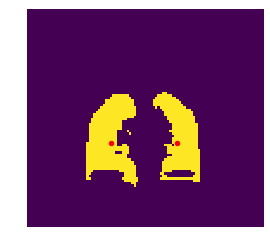

______________________________________________________________________________________________________
40584316
40584316


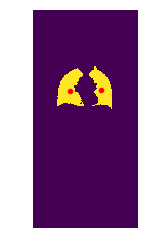

______________________________________________________________________________________________________
41265741
41265741


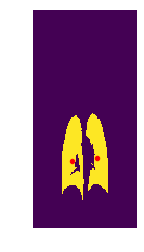

______________________________________________________________________________________________________
42242822


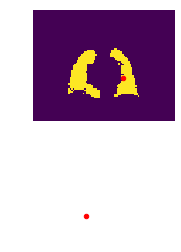

______________________________________________________________________________________________________
42715988
42715988


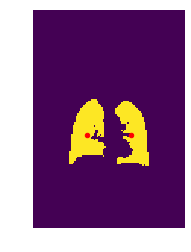

______________________________________________________________________________________________________
43109032
43109032


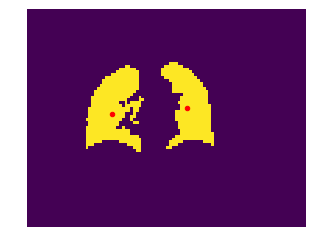

______________________________________________________________________________________________________
43151324
43151324


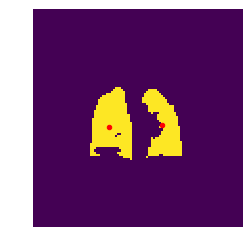

______________________________________________________________________________________________________
43181879
43181879


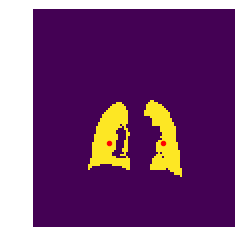

______________________________________________________________________________________________________
43266075
43266075


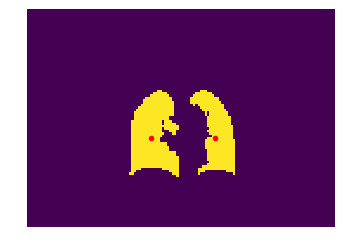

______________________________________________________________________________________________________
43405561
43405561
43405561


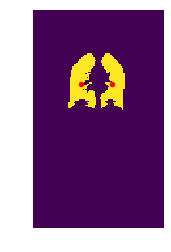

______________________________________________________________________________________________________
43675706
43675706


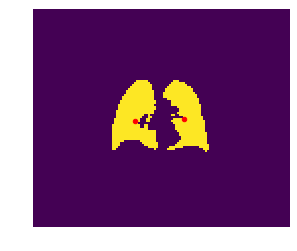

______________________________________________________________________________________________________
44120063
44120063


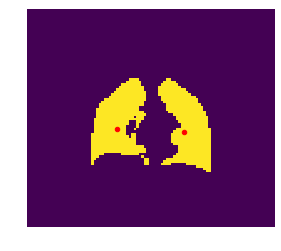

______________________________________________________________________________________________________
44253050
44253050


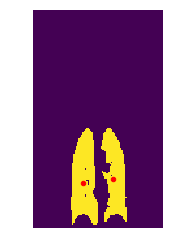

______________________________________________________________________________________________________
44422897
44422897


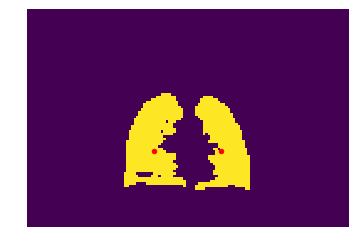

______________________________________________________________________________________________________
45858788
45858788


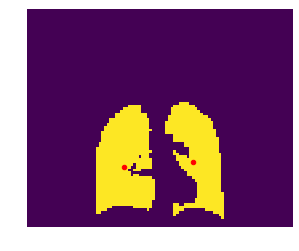

______________________________________________________________________________________________________
46318956
46318956


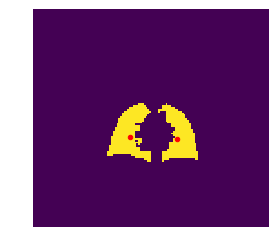

______________________________________________________________________________________________________
47262863
47262863


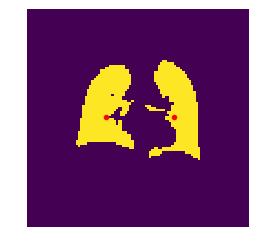

______________________________________________________________________________________________________
47295940
47295940


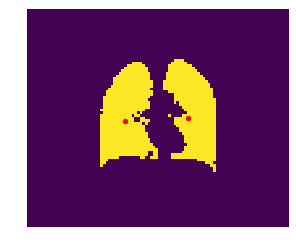

______________________________________________________________________________________________________
48148279
48148279


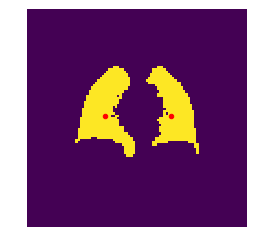

______________________________________________________________________________________________________
48259441
48259441
Im zero
Im zero


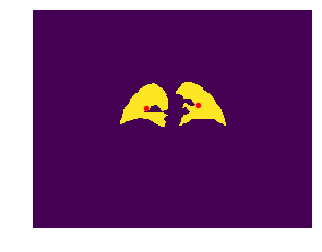

______________________________________________________________________________________________________
48335198


FileNotFoundError: [Errno 2] No such file or directory: 'G:/Ana Tese/CISUC-BD/Masks/pares/mask_48335198.npy'

In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import scipy.io as spio
import pydicom
import time
from math import log
import nibabel as nib
from nilearn import image
import sys
from preprocess import creating_mask
from scipy.ndimage import zoom
from skimage import measure


from preprocess import arrange_slices

sys.path.insert(0,'C:/3DUnetCNN-master/brats/')
from preprocess_ipo_utils import HU_conversion, read_data

sys.path.insert(0,'3DRegionGrowing/')
from segmentation_functions import resample

#patient_id = "40433190"

in_folder_2= "G:/CTimages/original/"
mask_folder = "G:/Masks/pares/"
separate_mask_folder = "G:/Masks/separated/"
separation_path = "G:/Results/Separator/"
rg_results_path = "G:/Results/segmentation_results/Iterative/third/"
rg_folder = os.listdir(rg_results_path)
for num,pre_id in enumerate(rg_folder):
    patient_id= pre_id.split("_")[1] 
    next_patient_id= rg_folder[num+1].split("_")[1] 
    #patient = pre_patient.split()
    print(patient_id)
    if (patient_id != next_patient_id):
        in_folder= "G:/CTimages/original/"+patient_id+"/"

        #volume
        slices, affine,first_slice = read_data(in_folder, True)
        scans = arrange_slices(in_folder_2, patient_id)
        hu_volume=HU_conversion(slices, first_slice)
        hu_array = np.array(hu_volume)
        trans = np.flip(hu_array.transpose(2,1,0),2)
        data = np.flip(trans,0)
        volume_resampled,spacing = resample(data, scans, [5,5,5])

        #Ground truth mask 
        mask = np.load(mask_folder+"mask_"+patient_id+'.npy')
        ground_truth_resampled, spacing = resample(mask, scans, [5,5,5]) 
        mask_boolean= np.where(ground_truth_resampled>0.5, 1, 0)

        #Seed
        seeds_path = "G:/Results/Centroids/New_method"
        probable_name_left = "centroid_"+patient_id+"_left"
        probable_rg_file_left = [i for i in os.listdir(seeds_path) if os.path.isfile(os.path.join(seeds_path,i)) and \
         probable_name_left in i]
        if len(probable_rg_file_left) != 0:
            seed_1 = np.load(seeds_path+'/'+probable_rg_file_left[0])
            seed_1_rounded = [np.int(seed_1[0]),np.int(seed_1[1]),np.int(seed_1[2])]
         
        probable_name_right = "centroid_"+patient_id+"_right"
        probable_rg_file_right = [i for i in os.listdir(seeds_path) if os.path.isfile(os.path.join(seeds_path,i)) and \
        probable_name_right in i]
        if len(probable_rg_file_right) != 0:
            seed_2 = np.load(seeds_path+'/'+probable_rg_file_right[0])
            seed_2_rounded = [np.int(seed_2[0]),np.int(seed_2[1]),np.int(seed_2[2])]
        
        if (seed_1_rounded not in mask_boolean) or (seed_2_rounded not in mask_boolean):
            img_folder = "C:/images/comparison_results/applied mask/"    
            plt.figure()
            plt.axis('off')
            plt.imshow(mask_boolean[:,np.int(seed_1[1]),:])
            plt.scatter([np.int(seed_1[2]),np.int(seed_2[2])], [np.int(seed_1[0]),np.int(seed_2[0])],c='red', s=20)
            #plt.savefig(img_folder+patient_id+'_centroid'+'.png', bbox_inches='tight')
            plt.show()
            print("______________________________________________________________________________________________________")
            # img = plot_results_segmentation_image(ground_truth_boolean[:,half_rows,:],result_segment_boolean[:,half_rows,:],volume_resampled[:,half_rows,:])    


# seed_1_rounded

10194022
10194022


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


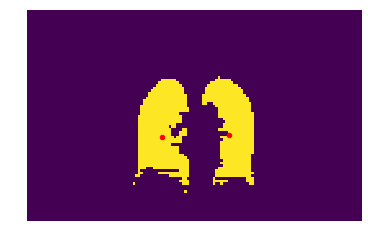

______________________________________________________________________________________________________
28838683
28838683


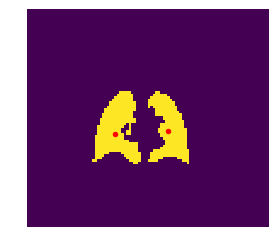

______________________________________________________________________________________________________
31022832
31022832


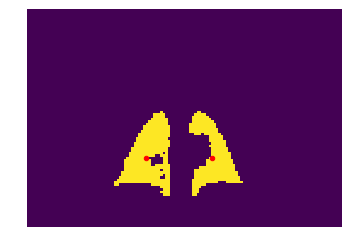

______________________________________________________________________________________________________
31119444
31119444


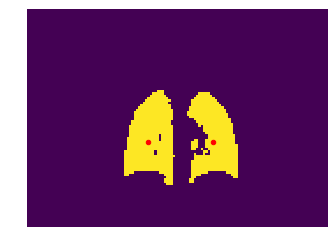

______________________________________________________________________________________________________
32064030


ValueError: operands could not be broadcast together with shapes (94,130,130) (214,100,100) 

In [6]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import scipy.io as spio
import pydicom
import time
from math import log
import nibabel as nib
from nilearn import image
import sys
from preprocess import creating_mask
from scipy.ndimage import zoom
from skimage import measure
from scipy import ndimage


from preprocess import arrange_slices

sys.path.insert(0,'C:/3DUnetCNN-master/brats/')
from preprocess_ipo_utils import HU_conversion, read_data

sys.path.insert(0,'3DRegionGrowing/')
from segmentation_functions import resample

in_folder_2= "G:/CTimages/original/"
mask_folder = "G:/Masks/pares/"
rg_results_path = "G:/Results/segmentation_results/Iterative/third/"
rg_folder = os.listdir(rg_results_path)
patient_id= "42242822"
in_folder= "G:/CTimages/original/"+patient_id+"/"
separate_mask_folder = "G:/Masks/separated/"
separation_path = "G:/Results/Separator/"

for num,pre_id in enumerate(rg_folder):
    patient_id= pre_id.split("_")[1] 
    next_patient_id= rg_folder[num+1].split("_")[1] 
    #patient = pre_patient.split()
    print(patient_id)
    if (patient_id != next_patient_id):
        in_folder= "G:/CTimages/original/"+patient_id+"/"

        slices, affine,first_slice = read_data(in_folder, True)
        scans = arrange_slices(in_folder_2, patient_id)
        hu_volume=HU_conversion(slices, first_slice)
        hu_array = np.array(hu_volume)
        trans = np.flip(hu_array.transpose(2,1,0),2)
        data = np.flip(trans,0)
        volume_resampled,spacing = resample(data, scans, [5,5,5])

        #Seed
        probable_name_left = "mask_"+patient_id+"_left"
        probable_rg_file_left = [i for i in os.listdir(separate_mask_folder) if os.path.isfile(os.path.join(separate_mask_folder,i)) and \
         probable_name_left in i]
        if len(probable_rg_file_left) != 0:
            left_mask = np.load(separate_mask_folder+'/'+probable_rg_file_left[0])
            ground_truth_resampled, spacing = resample(left_mask, scans, [5,5,5]) 
            left_lung= np.where(ground_truth_resampled>0.5, 1, 0)
            centroid_1 = tuple(ndimage.measurements.center_of_mass(left_lung))
            seed_1_rounded = [np.int(centroid_1[0]),np.int(centroid_1[1]),np.int(centroid_1[2])]  
        probable_name_right = "mask_"+patient_id+"_right"
        probable_rg_file_right = [i for i in os.listdir(separate_mask_folder) if os.path.isfile(os.path.join(separate_mask_folder,i)) and \
        probable_name_right in i]
        if len(probable_rg_file_right) != 0:
            right_mask = np.load(separate_mask_folder+'/'+probable_rg_file_right[0])
            ground_truth_resampled, spacing = resample(right_mask, scans, [5,5,5]) 
            right_lung= np.where(ground_truth_resampled>0.5, 1, 0)
            centroid_2 = tuple(ndimage.measurements.center_of_mass(right_lung))
            seed_2_rounded = [np.int(centroid_2[0]),np.int(centroid_2[1]),np.int(centroid_2[2])]  
        both_lungs = left_lung+right_lung

        if (seed_1_rounded not in both_lungs) or (seed_2_rounded not in both_lungs):
            img_folder = "C:/images/comparison_results/applied mask/"    
            plt.figure()
            plt.axis('off')
            plt.imshow(both_lungs[:,np.int(seed_1_rounded[1]),:])
            plt.scatter([np.int(seed_1_rounded[2]),np.int(seed_2_rounded[2])], [np.int(seed_1_rounded[0]),np.int(seed_2_rounded[0])],c='red', s=20)
            #plt.savefig(img_folder+patient_id+'_centroid'+'.png', bbox_inches='tight')
            plt.show()
            print("______________________________________________________________________________________________________")
            # img = plot_results_segmentation_image(ground_truth_boolean[:,half_rows,:],result_segment_boolean[:,half_rows,:],volume_resampled[:,half_rows,:])    
